In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [ ]:
import pandas as pd
import numpy as np
from winkie import ml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf
import imblearn

In [ ]:
segmented_timeseries = np.load("segments.npy")
label_vector= np.load("label.npy")
label_names = np.load("label-names.npy")

In [ ]:
# oversampling
from collections import Counter
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()

decoded_y = np.argmax(label_vector, axis=1)
print(Counter(decoded_y))

nsamples, nx, ny = segmented_timeseries.shape
reshaped_train_dataset = segmented_timeseries.reshape((nsamples, nx * ny))
x_over, y_over = oversample.fit_resample(reshaped_train_dataset, decoded_y)

print(Counter(y_over))

segmented_timeseries = x_over.reshape(x_over.shape[0], nx, ny)
df_encoded_labels = pd.get_dummies(y_over)
label_vector = np.asarray(df_encoded_labels, dtype = np.float32)

Counter({1: 423016, 4: 25444, 3: 10152, 0: 9891, 8: 8620, 5: 4159, 9: 3398, 7: 2949, 2: 2434, 6: 2111})
Counter({7: 423016, 6: 423016, 9: 423016, 5: 423016, 4: 423016, 1: 423016, 2: 423016, 3: 423016, 0: 423016, 8: 423016})


Output neurons: 10
Epoch 1/100
6610/6610 [==============================] - 83s 12ms/step - loss: 1.9938 - categorical_accuracy: 0.2839
Epoch 2/100
6610/6610 [==============================] - 74s 11ms/step - loss: 1.3805 - categorical_accuracy: 0.5201
Epoch 3/100
6610/6610 [==============================] - 71s 11ms/step - loss: 1.1536 - categorical_accuracy: 0.5989
Epoch 4/100
6610/6610 [==============================] - 72s 11ms/step - loss: 1.0197 - categorical_accuracy: 0.6446
Epoch 5/100
6610/6610 [==============================] - 78s 12ms/step - loss: 0.9188 - categorical_accuracy: 0.6790
Epoch 6/100
6610/6610 [==============================] - 75s 11ms/step - loss: 0.8478 - categorical_accuracy: 0.7032
Epoch 7/100
6610/6610 [==============================] - 72s 11ms/step - loss: 0.7858 - categorical_accuracy: 0.7248
Epoch 8/100
6610/6610 [==============================] - 69s 10ms/step - loss: 0.7399 - categorical_accuracy: 0.7410
Epoch 9/100
6610/6610 [======================

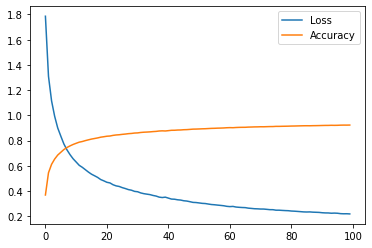

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(segmented_timeseries, label_vector, test_size=0.2, stratify=label_vector)
model = ml.build_lstm_model(x_train, label_vector)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
hist = model.fit(x_train,
            y_train,
            batch_size=512,
            epochs=100,
            verbose=1, callbacks=[tensorboard_callback])
    
plt.plot(hist.history['loss'], label="Loss")
plt.plot(hist.history['categorical_accuracy'], label="Accuracy")
plt.legend()
plt.show()

1653/1653 [==============================] - 9s 5ms/step - loss: 7.9360 - categorical_accuracy: 0.1990


'test loss: 7.936042785644531\ttest accuracy: 0.19901256263256073'

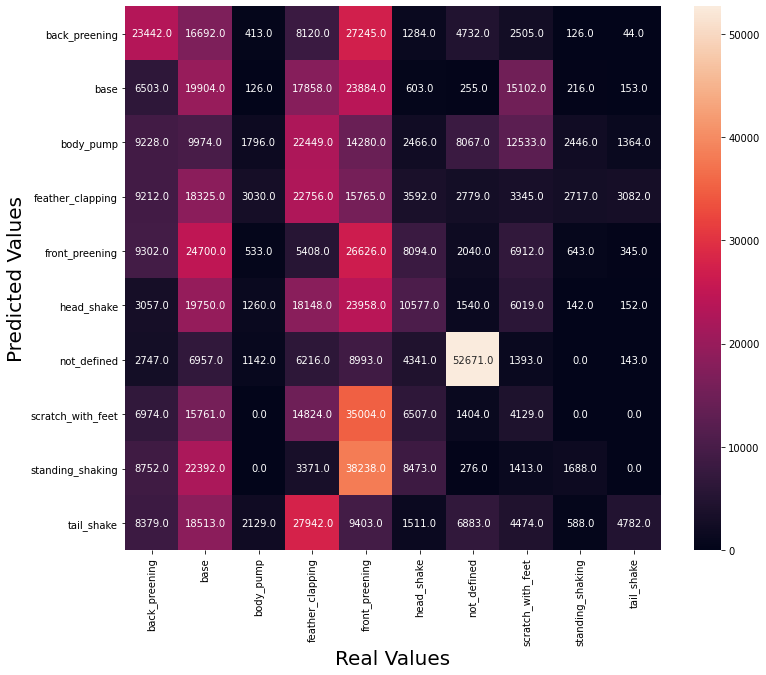

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=512)
display(f"test loss: {results[0]}\ttest accuracy: {results[1]}")


# getting predicted values for test data
y_pred = model.predict(x_test)

# matching true labels to predicted output
y_true=np.argmax(y_test, axis=1)
confusion = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

df_cm = pd.DataFrame(confusion)
plt.figure(figsize = (12,10))

sn.heatmap(df_cm, annot=True, fmt=".1f", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Real Values", fontsize=20)
plt.ylabel("Predicted Values", fontsize=20)
plt.show()

In [ ]:
model.save("model_7s-lstm-oversampling-sliding")

INFO:tensorflow:Assets written to: model_7s-lstm-oversampling-sliding\assets


INFO:tensorflow:Assets written to: model_7s-lstm-oversampling-sliding\assets


0.35074937
0.35069522
[0.         0.5216913  0.02955665 0.         0.00763686 0.
 0.         0.         0.         0.        ]


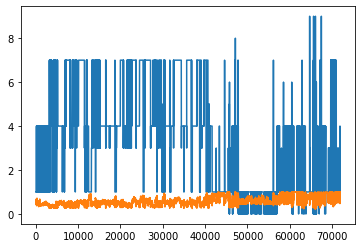

In [ ]:
import pandas as pd
import numpy as np
from winkie import ml
from winkie import dlc_importer
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
import datetime
import re

features = [('head', 'x'), ('head', 'y'), ('tail', 'x'), ('left_neck', 'y'), ('right_neck', 'y')]

def build_timeseries(df, features, timeslice_length, sliding):
    "Split the data in `df` into timeseries segments of length `timeslice_length` containing given `features`."
    
    segments = []
    
    if sliding:
        step = 1
    else:
        step = timeslice_length
    
    for i in range(0, len(df) - timeslice_length + 1, step):
        s = []
        i_end = i + timeslice_length
        for f in features:
            s.append(df[f[0], f[1]].values[i:i_end])
            
        segments.append(s)

    return np.asarray(segments).reshape(-1, timeslice_length, len(features))



def apply_model_and_check_performance(model_name, result_file_name, expted_label_file_name, label_mapping, sliding=False):
    p = re.compile(r'(^[A-Za-z_]*) *= *(?:slice)? ?\((\d*), ?(\d*)\)')
    behaviours = []
    with open(expted_label_file_name) as f:
      for x in f:
        m = p.match(x)
        frames = int(m.group(3)) - int(m.group(2))
        b = m.group(1)
        behaviours += frames * [b]
    expected = pd.Series(behaviours)
    
    model = keras.models.load_model(model_name)
    
    imp = dlc_importer.DLCImporter()
    df = imp.import_hdf(result_file_name)
    df['expected'] = expected

    
    timeslice = 7
    segments = build_timeseries(df, features, timeslice, sliding=sliding)

    predictions = model.predict(segments)

    if sliding:
        classes = pd.Series(np.argmax(predictions, axis = 1))
        confidence = pd.Series(np.max(predictions, axis = 1))
    else:
        classes = pd.Series(np.argmax(predictions, axis = 1)).repeat(timeslice).reset_index(drop=True)
        confidence = pd.Series(np.max(predictions, axis = 1)).repeat(timeslice).reset_index(drop=True)

    df['class'] = classes
    df['class'] = df['class'].replace(np.NaN, 1.0)
    df['b'] = df.apply(lambda row: label_mapping[int(row['class'])], axis=1)

    df['confidence'] = confidence
    
    df_anomalies = df[(df['class'] != 1.0) & (df['class'] != -1.0)]
    df_anomalies.groupby((df_anomalies['class'].shift() != df_anomalies['class']).cumsum())

    recall = []

    for k, v in df_anomalies.groupby((df_anomalies['class'].shift() != df_anomalies['class']).cumsum()):
        recall.append([
            v['b'].head(1).values[0], 
            v['expected'].unique(), 
            v['expected'].head(1).values[0],
            datetime.timedelta(seconds=v.head(1).index.values[0] / 119.88),
            len(v), 
            v.head(1).index.values[0],
            v.tail(1).index.values[0]])

    df_performance = pd.DataFrame(recall, columns=['detected', 'expected', 'confidence', 'time', 'length', 'start', 'end'])
    
    return df, df_performance, predictions

label_mapping = [
    'back_preening', 'base', 'body_pump', 'feather_clapping', 'front_preening', 'head_shake', 'not_defined',
    'scratch_with_feet', 'standing_shaking', 'tail_shake']



df, df_p, pred = apply_model_and_check_performance("model_7s-lstm-sliding", 
    '233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5', 
    "completely_labelled_233monhabday1.txt", label_mapping, sliding=True)

df['class'].plot()
df['confidence'].plot()

def calc_accuracy(df):
    ytrue = df['expected_class']
    ypred = df['class']

    metric = tf.keras.metrics.Accuracy()
    metric.update_state(ytrue, ypred)
    print(metric.result().numpy())

expected_class_lookup = {
    'eating': 1.0,
    'standing': 1.0,
    'hp': 5.0,
    'walking': 1.0,
    'fp': 4.0,
    'sf': 7.0,
    'bp': 2.0,
    'eating_flor': 1.0,
    np.NAN: 1.0
}

df['expected_class'] = df.apply(lambda row: expected_class_lookup[row['expected'][0]], axis=1)

calc_accuracy(df)

ytrue = []
for i, v in df['expected_class'].items():
    exp = [0] * 10
    exp[int(v)] = 1
    ytrue.append(exp)

metric = tf.keras.metrics.CategoricalAccuracy()
metric.update_state(ytrue[:-6], pred)
print(metric.result().numpy())

metric = tfa.metrics.F1Score(num_classes=len(ytrue[0]), threshold=None)
metric.update_state(ytrue[:-6], pred)
print(metric.result().numpy())